# Training a CNN on the CIFAR-10 dataset

#### Types of datasets when working with classifiers.
- Image datasets
- Text datasets
- Audio datasets

#### Data conversion / preprocessing.
> Use a python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor

#### Packages generally used.
- Image datasets: Pillow, OpenCV
- Text datasets: NLTK, SpaCy
- Audio datasets: Librosa, SciPy

### CIFAR-10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

<img title="CIFAR10" alt="CIFAR10 Classes" src="images/cifar-classes.png">

### Traing an image classifier for CIFAR-10 dataset

1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
is_cuda = torch.cuda.is_available()
is_mps = torch.backends.mps.is_available()

# If we have a GPU available, we'll set our device to GPU. 
# We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
elif is_mps:
    device = torch.device("mps")
    print("MPS is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Let’s start by loading and then pre-processing the data. For our purposes, we will be using the CIFAR-10 dataset. The dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [3]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# Transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
            'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


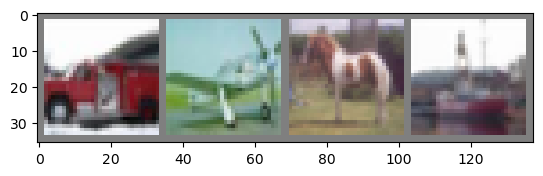

truck plane horse ship 


In [4]:
# Print training images
import matplotlib.pyplot as plt
import numpy as np

# Function to show image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a random training image
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Plot image
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = CNNet().to(device)

### 3. Define loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 4. Train the Network

In [7]:
total_step = len(trainloader)
epochs = 2
for epoch in range(epochs):
    loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # list of [inputs, ground truth labels]
        inputs, gt_labels = data[0].to(device), data[1].to(device)

        # reset parameter gradients
        optimizer.zero_grad()

        # get predictions
        predictions = model(inputs)
        # calculate loss
        loss = criterion(predictions, gt_labels)
        # backpropagate
        loss.backward()
        # update weights
        optimizer.step()

        # print loss
        loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, epochs, i+1, total_step, loss))
            loss = 0.0

print('Finished Training')

Epoch [1/2], Step [2000/12500], Loss: 3.4186
Epoch [1/2], Step [4000/12500], Loss: 2.7800
Epoch [1/2], Step [6000/12500], Loss: 3.6651
Epoch [1/2], Step [8000/12500], Loss: 4.2376
Epoch [1/2], Step [10000/12500], Loss: 3.5145
Epoch [1/2], Step [12000/12500], Loss: 2.2131
Epoch [2/2], Step [2000/12500], Loss: 2.9492
Epoch [2/2], Step [4000/12500], Loss: 1.7378
Epoch [2/2], Step [6000/12500], Loss: 4.6946
Epoch [2/2], Step [8000/12500], Loss: 3.3223
Epoch [2/2], Step [10000/12500], Loss: 1.0387
Epoch [2/2], Step [12000/12500], Loss: 2.5502
Finished Training


### Save the mode

In [8]:
PATH = "./models/cifar_net.pth"
torch.save(model.state_dict(), PATH)

### 5. Test the model on test data

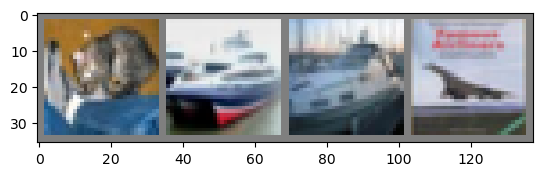

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
test_images, gt_labels = next(dataiter)

#print images

imshow(torchvision.utils.make_grid(test_images))
print('GroundTruth: ', ' '.join('%5s' % classes[gt_labels[j]] for j in range(4)))

In [10]:
model_inf = CNNet().to(device)
model_inf.to(device)
model_inf.load_state_dict(torch.load('models/cifar_net_inference.pth'))
model_inf.eval()

/tmp/ipykernel_27738/669341045.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_inf.load_state_dict(torch.load('models/cifar_net_inference.pth'))


CNNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [11]:
test_predictions = model_inf(test_images.to(device))

In [12]:
_, predicted = torch.max(test_predictions, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [13]:
# dictionary to store predictions of each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# since prediction no gradient are needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        predictions = model_inf(images)
        _, predictions = torch.max(predictions, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.2 %
Accuracy for class: car   is 65.2 %
Accuracy for class: bird  is 23.6 %
Accuracy for class: cat   is 30.7 %
Accuracy for class: deer  is 56.7 %
Accuracy for class: dog   is 39.5 %
Accuracy for class: frog  is 77.8 %
Accuracy for class: horse is 63.3 %
Accuracy for class: ship  is 76.4 %
Accuracy for class: truck is 62.3 %


### 6. Try use a different model
#### AlexNet
- Developed by Alex Krizhevsky and his colleagues back in 2012
- Was designed to classify images for the ImageNet LSVRC-2010 competition

Operation:
- 3-channel images that were (224x224x3) in size.
- max pooling along with ReLU activations when subsampling
- convolutions were either 11x11, 5x5, or 3x3
- max pooling kernels were 3x3 in size
- classified images into 1000 classes.

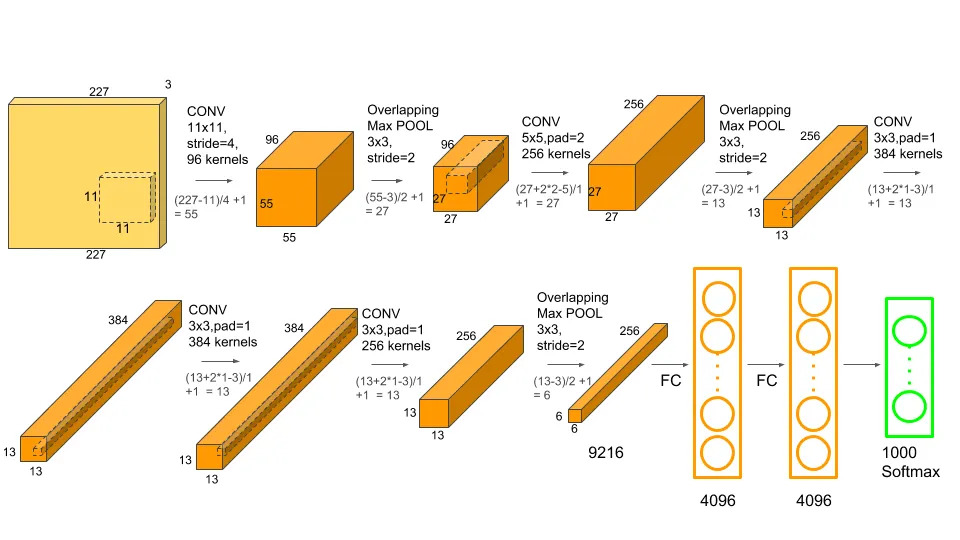

In [8]:
normalize = transforms.Normalize(
            mean=[.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5],
        )

# define transforms
validation_transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
])

batch_size = 64

trainset_vgg = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=False,
    transform=transform
)

testset_vgg = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=False,
    transform=transform
)

trainloader_vgg = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

testloader_vgg = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
            'dog', 'frog', 'horse', 'ship', 'truck')

NameError: name 'transforms' is not defined

The code specifies two key parameters:

- Mean values [0.4914, 0.4822, 0.4465] - one for each RGB color channel
- Standard deviation values [0.2023, 0.1994, 0.2010] - also one per RGB channel

The purpose of these values is to standardize the input images so that each color channel has similar scales and distributions, which helps neural networks train more effectively by ensuring all pixel values are in a reasonable range.

In [51]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 64

def get_training_and_validation_loader(data_dir,
                        batch_size,
                        augment,
                        random_seed,
                        valid_size=0.1,
                        shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # specify data transformations accordingly
    validation_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=validation_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir, batch_size, shuffle=True):
    
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # specify data transformations accordingly
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader

# CIFAR10 data loaders 
train_loader, valid_loader = get_training_and_validation_loader(data_dir = './data', batch_size = batch_size, augment = False, random_seed = 1)

test_loader = get_test_loader(data_dir = './data', batch_size = batch_size)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [21]:
class AlexNet(nn.Module):
        def __init__(self, num_classes=10):
            super(AlexNet, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
                nn.BatchNorm2d(96),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer4 = nn.Sequential(
                nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer5 = nn.Sequential(
                nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(9216, 4096),
                nn.ReLU())
            self.fc1 = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU())
            self.fc2= nn.Sequential(
                nn.Linear(4096, num_classes))

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = self.layer5(out)
            out = out.reshape(out.size(0), -1)
            out = self.fc(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out
        
model_alexnet = AlexNet().to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay = 0.005, momentum = 0.9)

In [60]:
total_step = len(train_loader)

epochs = 10
model_alexnet.train()
for epoch in range(epochs):
    loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # list of [inputs, ground truth labels]
        inputs, gt_labels = data[0].to(device), data[1].to(device)

        # reset parameter gradients
        optimizer.zero_grad()

        # get predictions
        predictions = model_alexnet(inputs)
        
        # calculate loss
        loss = criterion(predictions, gt_labels)
        # backpropagate
        loss.backward()
        # update weights
        optimizer.step()

        # print loss
        loss += loss.item()
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, epochs, i+1, total_step, loss))

    # Validation
    with torch.no_grad():
      correct = 0
      total = 0
      for data in test_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model_alexnet(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          del images, labels, outputs
    
      print('Accuracy of the network on the {} validation images: {} %'
        .format(5000, 100 * correct / total))


print('Finished Training')

Epoch [1/10], Step [100/704], Loss: 4.6531
Epoch [1/10], Step [200/704], Loss: 4.6739
Epoch [1/10], Step [300/704], Loss: 4.6975
Epoch [1/10], Step [400/704], Loss: 4.6062
Epoch [1/10], Step [500/704], Loss: 4.6392
Epoch [1/10], Step [600/704], Loss: 4.8208
Epoch [1/10], Step [700/704], Loss: 4.6359
Accuracy of the network on the 5000 validation images: 10.9375 %
Accuracy of the network on the 5000 validation images: 9.375 %
Accuracy of the network on the 5000 validation images: 9.375 %
Accuracy of the network on the 5000 validation images: 8.984375 %
Accuracy of the network on the 5000 validation images: 8.75 %
Accuracy of the network on the 5000 validation images: 8.854166666666666 %
Accuracy of the network on the 5000 validation images: 8.705357142857142 %
Accuracy of the network on the 5000 validation images: 9.1796875 %
Accuracy of the network on the 5000 validation images: 10.590277777777779 %
Accuracy of the network on the 5000 validation images: 11.25 %
Accuracy of the network 

In [45]:
PATH = "./models/cifar_vgg_net.pth"
torch.save(model.state_dict(), PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


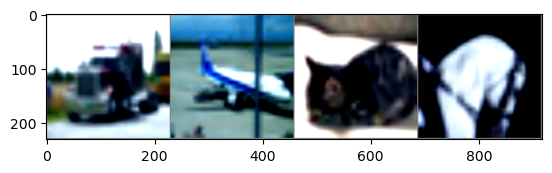

GroundTruth:  truck plane   cat horse


In [53]:
dataiter = iter(test_loader)
test_images, gt_labels = next(dataiter)

#print images

imshow(torchvision.utils.make_grid(test_images))
print('GroundTruth: ', ' '.join('%5s' % classes[gt_labels[j]] for j in range(4)))

In [54]:
test_predictions = model_alexnet(test_images.to(device))

In [55]:
_, predicted = torch.max(test_predictions, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  horse frog  horse ship 


In [56]:
# dictionary to store predictions of each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# since prediction no gradient are needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        predictions = model_alexnet(images)
        _, predictions = torch.max(predictions, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 1.2 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 1.0 %
Accuracy for class: cat   is 17.4 %
Accuracy for class: deer  is 5.6 %
Accuracy for class: dog   is 20.6 %
Accuracy for class: frog  is 35.4 %
Accuracy for class: horse is 12.3 %
Accuracy for class: ship  is 5.4 %
Accuracy for class: truck is 0.6 %
